In [1]:
import matplotlib.pyplot as plt          # type: ignore
import numpy as np                       # type: ignore
import pandas as pd                      # type: ignore
import seaborn as sns                    # type: ignore
import geopandas as gpd                  # type: ignore
import shapely.vectorized as sv          # type: ignore
from shapely import geometry as geom     # type: ignore
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import rasterio
from matplotlib import cm, colors as mcolors
from pathlib import Path
import os

In [2]:
sns.set(style="whitegrid", context="notebook")

In [3]:
df = sns.load_dataset("diamonds").dropna()

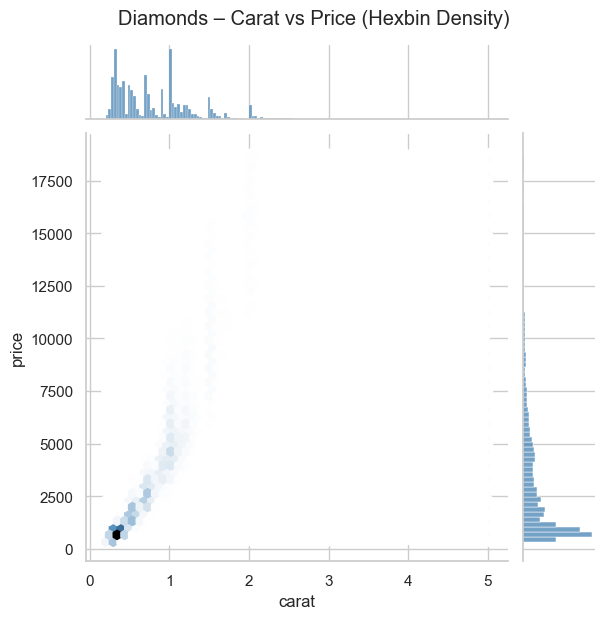

In [5]:
g = sns.jointplot(
    data=df.sample(50_000, random_state=42),
    x="carat",
    y="price",
    kind="hex",
    height=6,
    color="steelblue",
)
g.fig.suptitle("Diamonds – Carat vs Price (Hexbin Density)", y=1.03)
plt.show(g.fig)
plt.close(g.fig)

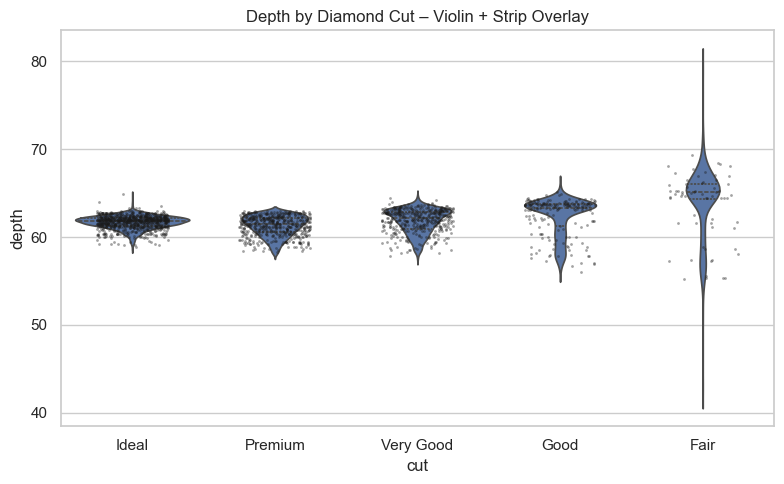

In [9]:
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df.sample(10_000, random_state=42),
    x="cut",
    y="depth",
    inner="quartile",
)
sns.stripplot(
    data=df.sample(2_000, random_state=42),
    x="cut",
    y="depth",
    color="k",
    size=2,
    alpha=0.4,
    jitter=0.25,
)
plt.title("Depth by Diamond Cut – Violin + Strip Overlay")
plt.tight_layout()
plt.show()
plt.close()

/var/folders/mt/p4xbqy111nd1_1s2y1lk_cbh0000gp/T/ipykernel_22554/513971471.py:27: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  europe_shape = europe.unary_union


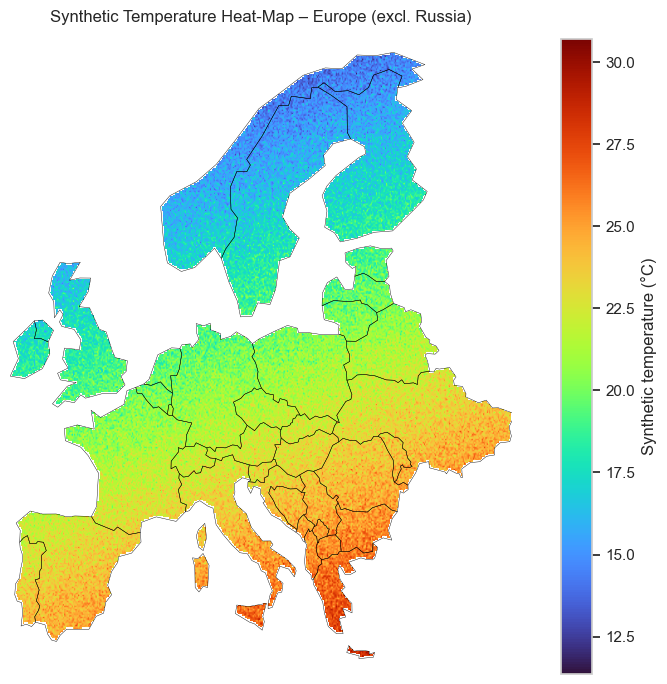

In [10]:
url = (
    "https://raw.githubusercontent.com/nvkelso/"
    "natural-earth-vector/master/geojson/"
    "ne_110m_admin_0_countries.geojson"
)
world = gpd.read_file(url)
cont_col = "continent" if "continent" in world.columns else "CONTINENT"

name_candidates = [
    "name",
    "NAME",
    "admin",
    "ADMIN",
    "name_long",
    "NAME_LONG",
]
name_col = next((c for c in name_candidates if c in world.columns), None)

europe = world[world[cont_col] == "Europe"].copy()
if name_col is not None:
    europe = europe[~europe[name_col].isin(["Russia", "Iceland", "Denmark"])].copy()

bbox = geom.box(-10.0, 34.0, 40.0, 72.0)
europe["geometry"] = europe.geometry.intersection(bbox)
europe = europe[~europe.geometry.is_empty].copy()

europe_shape = europe.unary_union
minx, miny, maxx, maxy = bbox.bounds

n = 400
lons = np.linspace(minx, maxx, n)
lats = np.linspace(miny, maxy, n)
lon_grid, lat_grid = np.meshgrid(lons, lats)

mask = sv.contains(europe_shape, lon_grid, lat_grid)

rng = np.random.default_rng(42)
values = (
    40
    - lat_grid * 0.4
    + lon_grid * 0.1
    + rng.normal(scale=1.0, size=lon_grid.shape)
)
values = np.where(mask, values, np.nan)

fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(
    values,
    extent=(minx, maxx, miny, maxy),
    origin="lower",
    cmap="turbo",
    interpolation="bilinear",
)
europe.boundary.plot(ax=ax, color="black", linewidth=0.3)
ax.set_axis_off()
fig.colorbar(im, ax=ax, label="Synthetic temperature (°C)")
ax.set_title("Synthetic Temperature Heat-Map – Europe (excl. Russia)", pad=12)
plt.tight_layout()
plt.show()
plt.close(fig)

In [10]:
RASTER_FILE = "a5/gpw_v4_population_density_rev11_2020_30_sec.tif"
TITLE = "Europe Population Density – Gridded Spike Map (log10 scale)"
BBOX = (-10, 34, 40, 72)
CLIPPED_TIF = RASTER_FILE

In [11]:
raster_path = Path(CLIPPED_TIF)
with rasterio.open(raster_path) as src:
    band = src.read(1)
    band = np.nan_to_num(band, nan=0)
    transform = src.transform

    rows, cols = np.meshgrid(np.arange(band.shape[0]), np.arange(band.shape[1]), indexing="ij")
    lons, lats = rasterio.transform.xy(transform, rows, cols)
    lons = np.array(lons).ravel()
    lats = np.array(lats).ravel()
    values = band.ravel()

    mask = (
        (values > 0) &
        (lons >= BBOX[0]) & (lons <= BBOX[2]) &
        (lats >= BBOX[1]) & (lats <= BBOX[3])
    )
    xs = lons[mask]
    ys = lats[mask]
    pop = values[mask]

    heights = np.log10(pop + 1)
    heights *= 0.6  # vertical exaggeration

    norm = mcolors.Normalize(vmin=heights.min(), vmax=heights.max())
    cmap = cm.get_cmap("Reds")
    colors = cmap(norm(heights))

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection="3d")
    ax.bar3d(xs, ys, np.zeros_like(xs), 0.2, 0.2, heights, color=colors, shade=True, zsort="max")

    ax.set_xlim(BBOX[0], BBOX[2])
    ax.set_ylim(BBOX[1], BBOX[3])
    ax.set_zlim(0, heights.max() * 1.25)
    ax.set_axis_off()
    ax.view_init(elev=60, azim=-75)
    ax.set_title(TITLE, pad=20)

    out_path =  "a5/europe_spike_grid.png"
    plt.tight_layout()
    fig.savefig(out_path, dpi=300)
    plt.close(fig)

RasterioIOError: a5/gpw_v4_population_density_rev11_2020_30_sec.tif: No such file or directory

In [ ]:
def population_spike_map_points(
    base_width: float = 0.15,
    height_scale: float = 0.5,
) -> None:

    world_url = (
        "https://raw.githubusercontent.com/nvkelso/"
        "natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson"
    )
    world = gpd.read_file(world_url)
    cont_col = "continent" if "continent" in world.columns else "CONTINENT"
    europe = world[world[cont_col] == "Europe"].copy()

    name_col = next(
        (c for c in ["name", "NAME", "admin", "ADMIN", "name_long", "NAME_LONG"] if c in world.columns),
        None,
    )
    if name_col is not None:
        europe = europe[~europe[name_col].isin(["Russia", "Iceland", "Denmark"])]

    bbox = geom.box(*BBOX)
    europe["geometry"] = europe.geometry.intersection(bbox)
    europe = europe[~europe.geometry.is_empty].copy()

    places_url = (
        "https://raw.githubusercontent.com/nvkelso/"
        "natural-earth-vector/master/geojson/ne_10m_populated_places_simple.geojson"
    )
    places = gpd.read_file(places_url)
    places = places.cx[BBOX[0] : BBOX[2], BBOX[1] : BBOX[3]].copy()
    pop_col = "POP_MAX" if "POP_MAX" in places.columns else "pop_max"
    places = places.dropna(subset=[pop_col])
    places = places[places[pop_col] > 0]
    places = places.nlargest(3000, pop_col)
    places["height"] = np.log10(places[pop_col] + 1.0) * height_scale

    fig = plt.figure(figsize=(11, 8))
    ax = fig.add_subplot(111, projection="3d")

    for geom_poly in europe.geometry:
        polys = geom_poly.geoms if geom_poly.geom_type == "MultiPolygon" else [geom_poly]
        for poly in polys:
            xs, ys = poly.exterior.coords.xy
            verts = [list(zip(xs, ys, np.zeros_like(xs)))]
            ax.add_collection3d(
                Poly3DCollection(
                    verts,
                    facecolors="#F5E8DA",
                    edgecolors="gray",
                    linewidths=0.2,
                )
            )

    raw_heights = np.log10(places[pop_col].values + 1.0)
    cmap = cm.get_cmap("Reds")
    colors = cmap(mcolors.Normalize(vmin=raw_heights.min(), vmax=raw_heights.max())(raw_heights))

    xs = places.geometry.x.values
    ys = places.geometry.y.values
    ax.bar3d(xs, ys, np.zeros_like(xs), base_width, base_width, places["height"].values, color=colors, shade=True)

    ax.view_init(elev=50, azim=-70)
    ax.set_xlim(BBOX[0], BBOX[2])
    ax.set_ylim(BBOX[1], BBOX[3])
    ax.set_zlim(0, places["height"].max() * 1.2)
    ax.set_axis_off()
    ax.set_title("European Population Density – City Point Spikes", pad=12)

    out_path = "a5/europe_population_spikes.png"
    plt.tight_layout()
    fig.savefig(out_path, dpi=300)
    plt.close(fig)